<a href="https://colab.research.google.com/github/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/blob/main/Ch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz

     |████████████████████████████████| 1.5MB 13.0MB/s 
     |████████████████████████████████| 4.7MB 57.0MB/s 
     |████████████████████████████████| 737kB 59.9MB/s 
     |████████████████████████████████| 296kB 52.7MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 10.2MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from sklearn import preprocessing
from theano import shared

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [4]:
def plot(x, y, mu_pred, y_pred, hdi_prob, ax, title, x_label, y_label):
  idx = np.argsort(x.values)
  x_ord = x.values[idx]
  mu_mean_ord = np.mean(mu_pred, axis=0)[idx]

  ax.scatter(x, y, c='C0', alpha=0.3)
  ax.plot(x_ord, mu_mean_ord, color='C2')
  az.plot_hpd(x, mu_pred, hdi_prob=hdi_prob, color='C2', ax=ax)
  az.plot_hpd(x, y_pred, hdi_prob=hdi_prob, color='C2', ax=ax)
  
  ax.set_xlabel(x_label, fontsize=14)
  ax.set_ylabel(y_label, fontsize=14)
  ax.set_title(title, fontsize=20)

In [5]:
# Import Data
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/WaffleDivorce.csv'
d = pd.read_csv(url, sep=';')
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [6]:
# Standarized Data
scaler = preprocessing.StandardScaler()
scaler.fit(d[['Divorce', 'Marriage', 'MedianAgeMarriage']])
d[['Divorce', 'Marriage', 'MedianAgeMarriage']] = scaler.transform(d[['Divorce', 'Marriage', 'MedianAgeMarriage']])
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,-0.612445,0.022874,1.27,1.671000,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,-0.693671,1.565536,2.93,1.560044,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,-0.206314,0.049472,0.98,0.616916,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,-1.424706,1.671927,1.70,2.114824,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,0.605947,-0.269700,0.39,-0.936470,0.24,0,0,0,379994,0.00


In [7]:
# Model Divorce Rate vs Median Age Marriage
with pm.Model() as model_5_1:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  betaA = pm.Normal('betaA', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + betaA * d.MedianAgeMarriage)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, betaA, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1295.32it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68fd328048>,
      dtype=object)

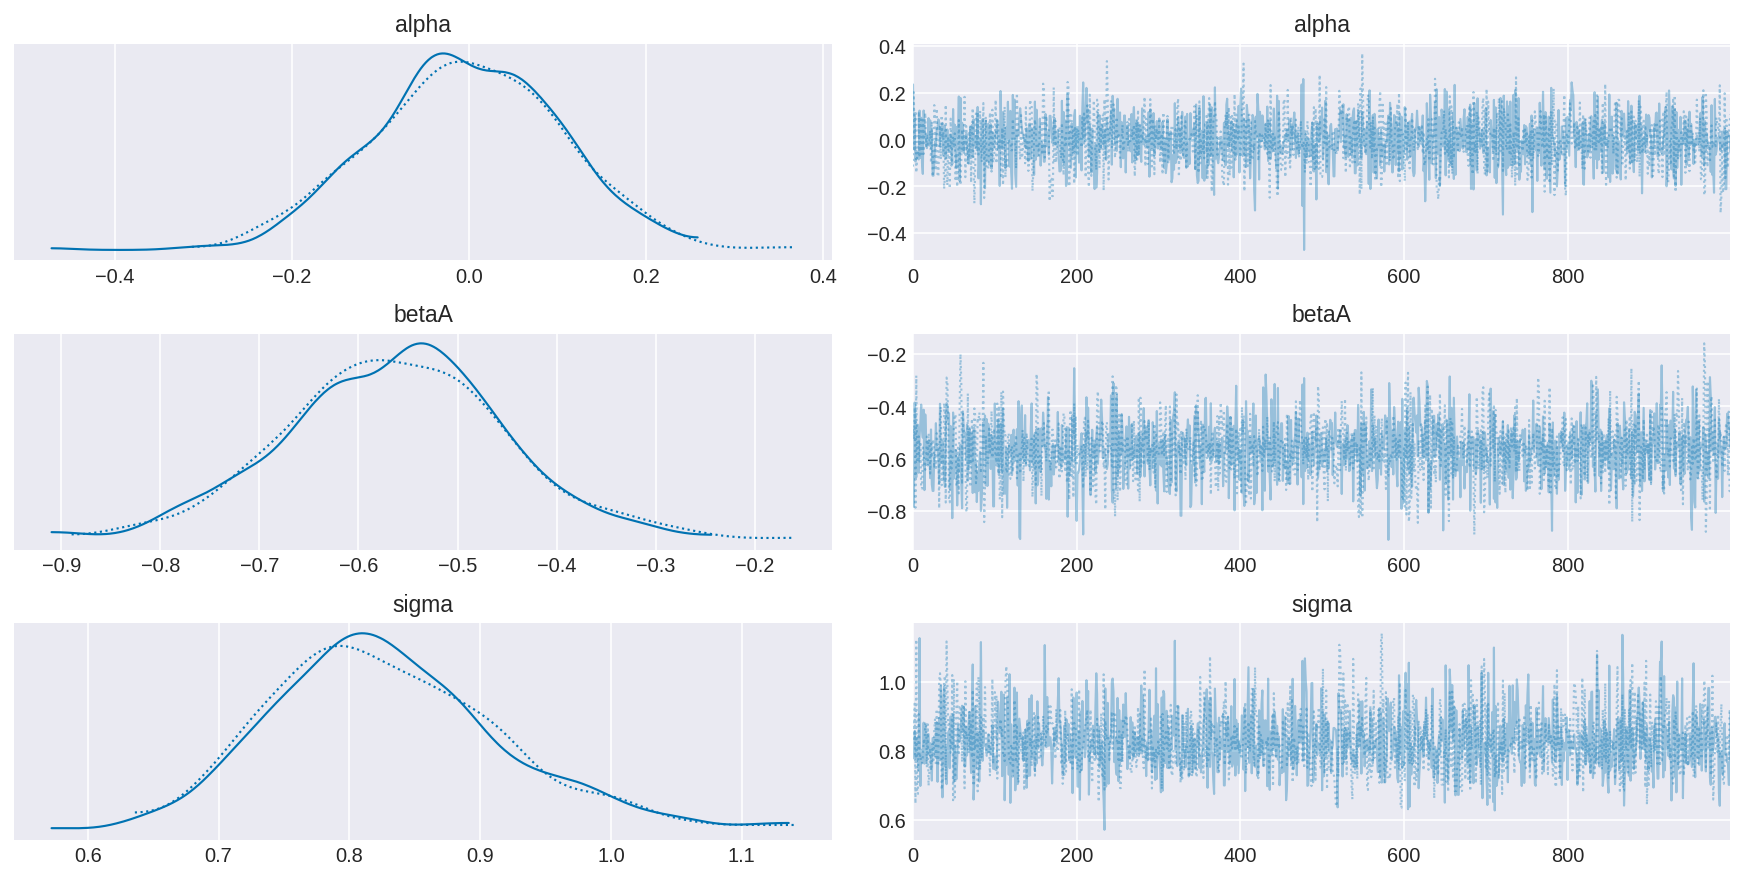

In [8]:
pm.traceplot(trace_5_1, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68f90b7eb8>],
      dtype=object)

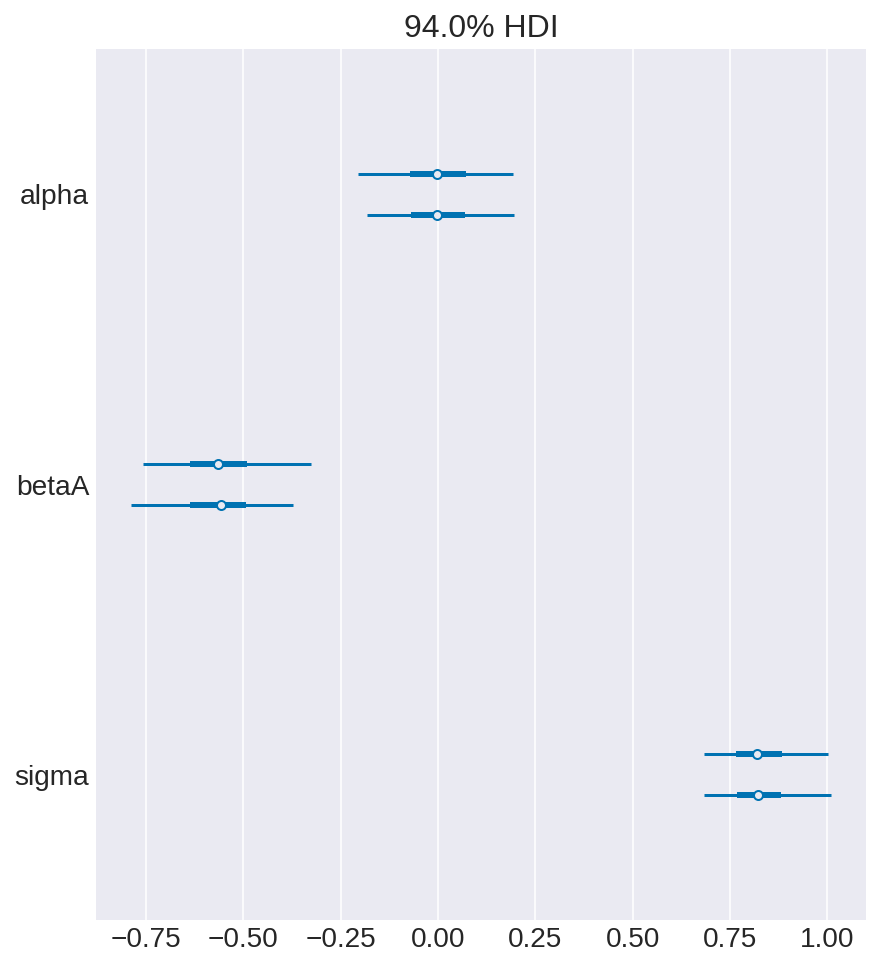

In [9]:
pm.forestplot(trace_5_1, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:01<00:00, 188.63it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


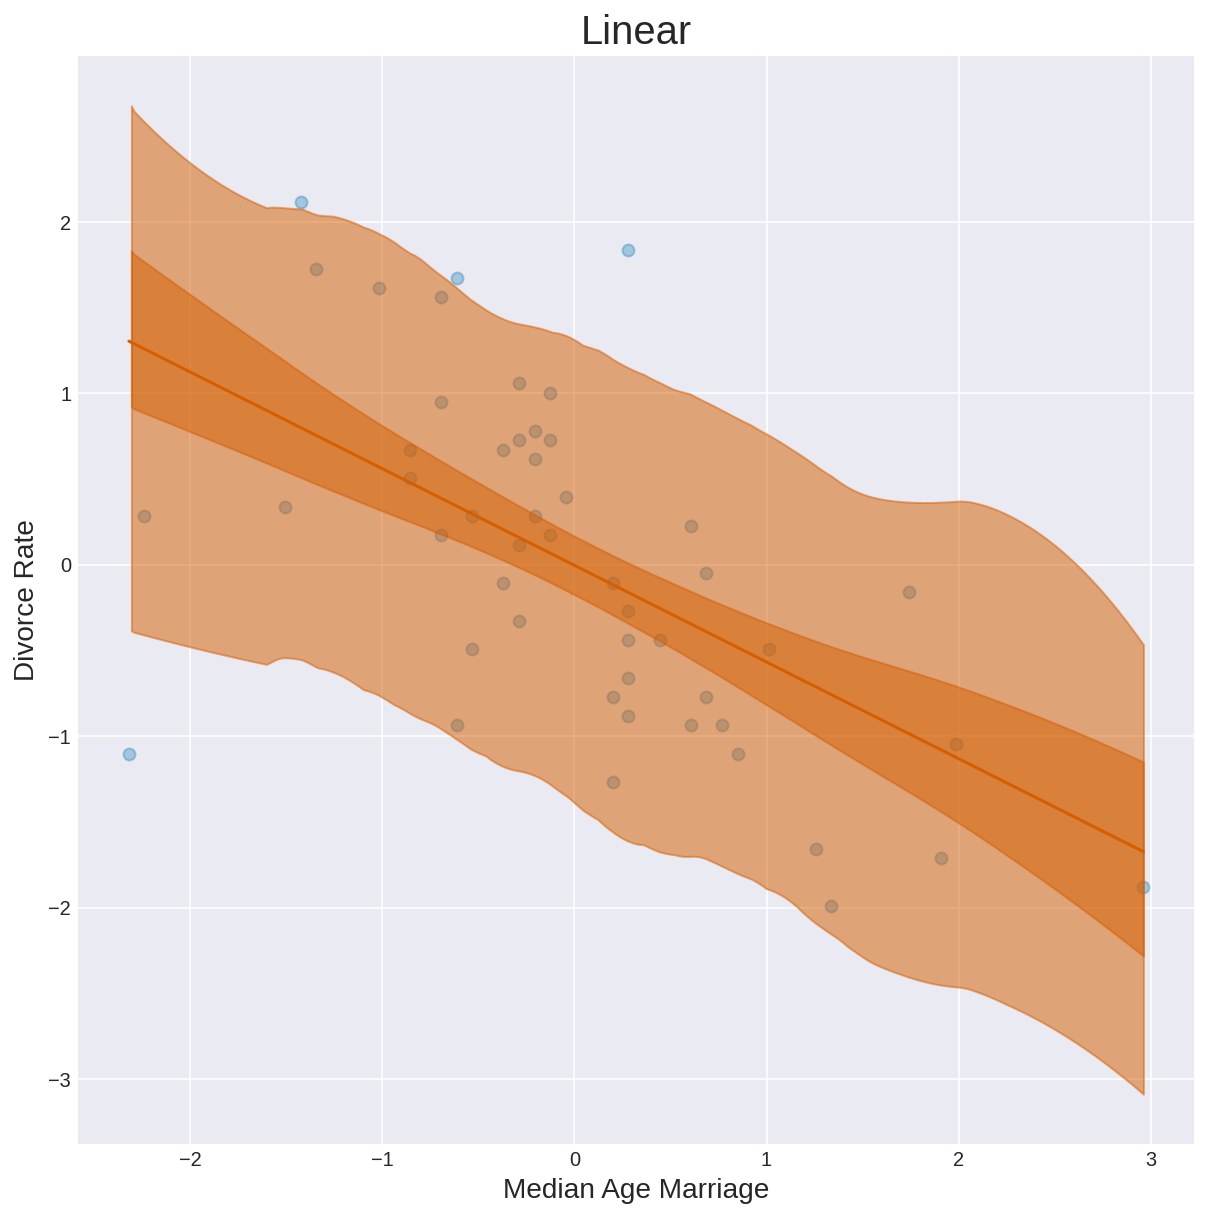

In [10]:
mu_pred = trace_5_1['mu']
y_pred = pm.sample_posterior_predictive(trace_5_1, 200, model_5_1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d.MedianAgeMarriage, d.Divorce, mu_pred, y_pred['divorce'], 0.9, ax, 'Linear', 'Median Age Marriage', 'Divorce Rate')

In [11]:
# Model Divorce Rate vs Marriage
with pm.Model() as model_5_6:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  betaA = pm.Normal('betaA', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + betaA * d.Marriage)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, betaA, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1184.61it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68f832bb70>,
      dtype=object)

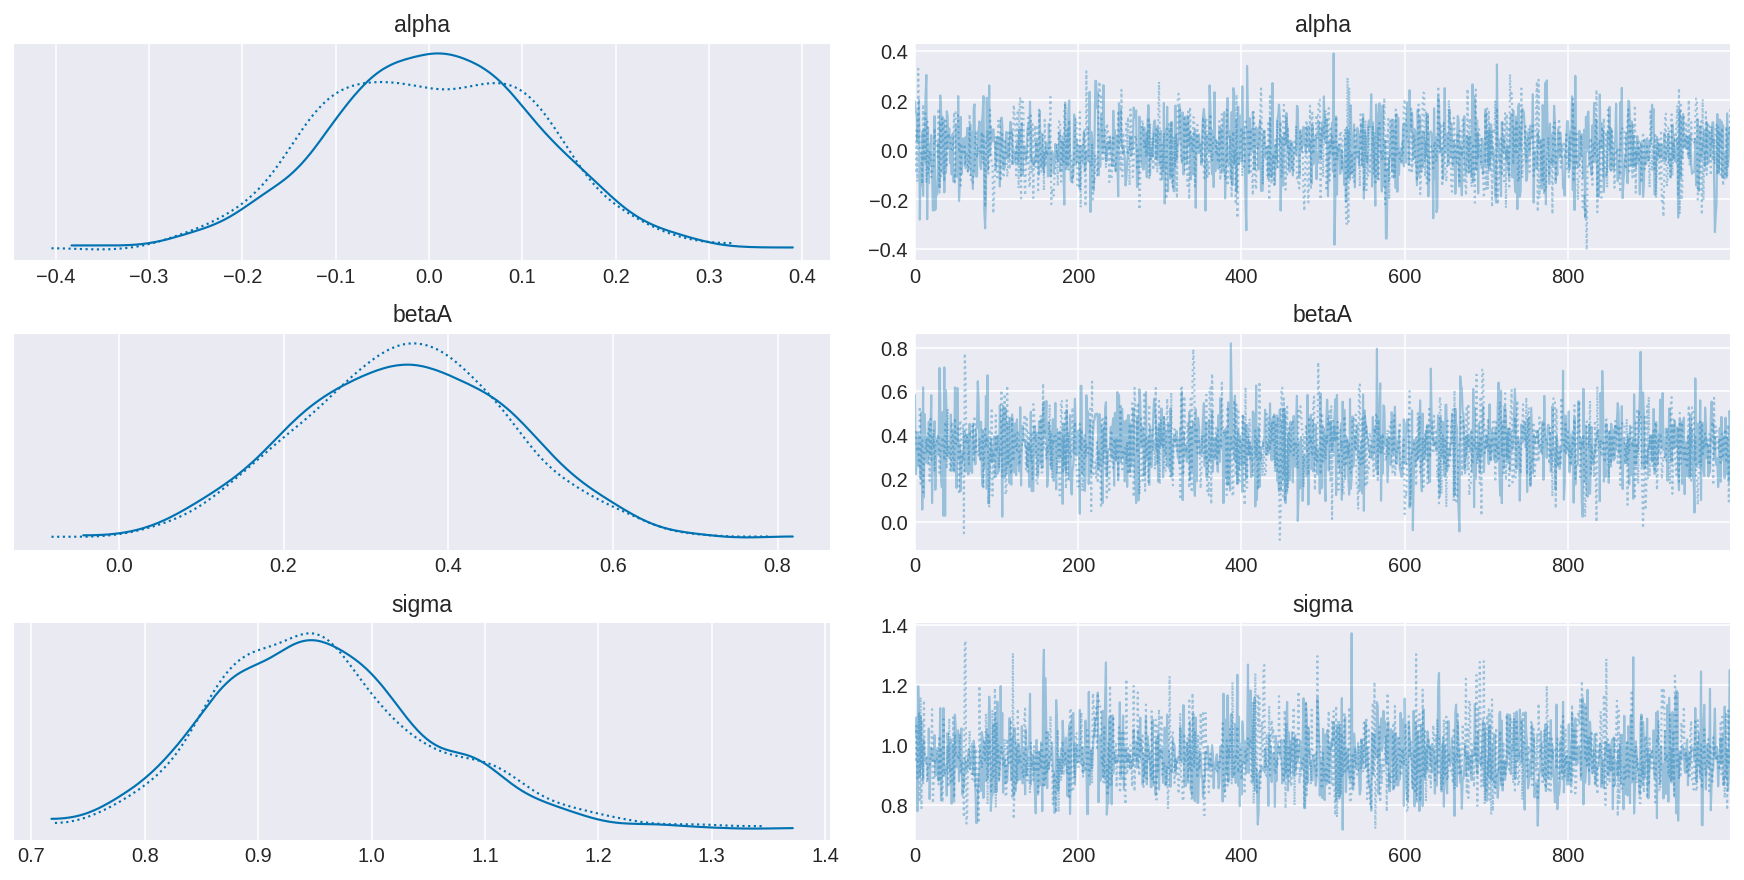

In [12]:
pm.traceplot(trace_5_6, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68fd3366a0>],
      dtype=object)

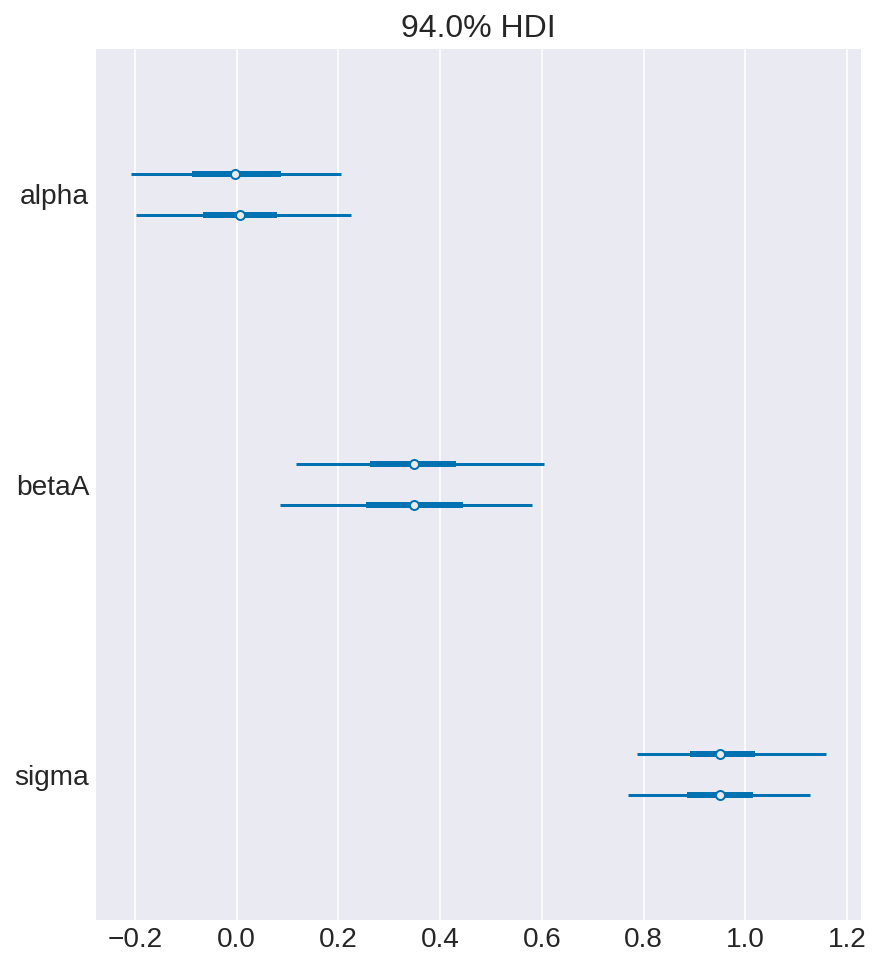

In [13]:
pm.forestplot(trace_5_6, var_names=['alpha', 'betaA', 'sigma'])

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 758.14it/s]
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


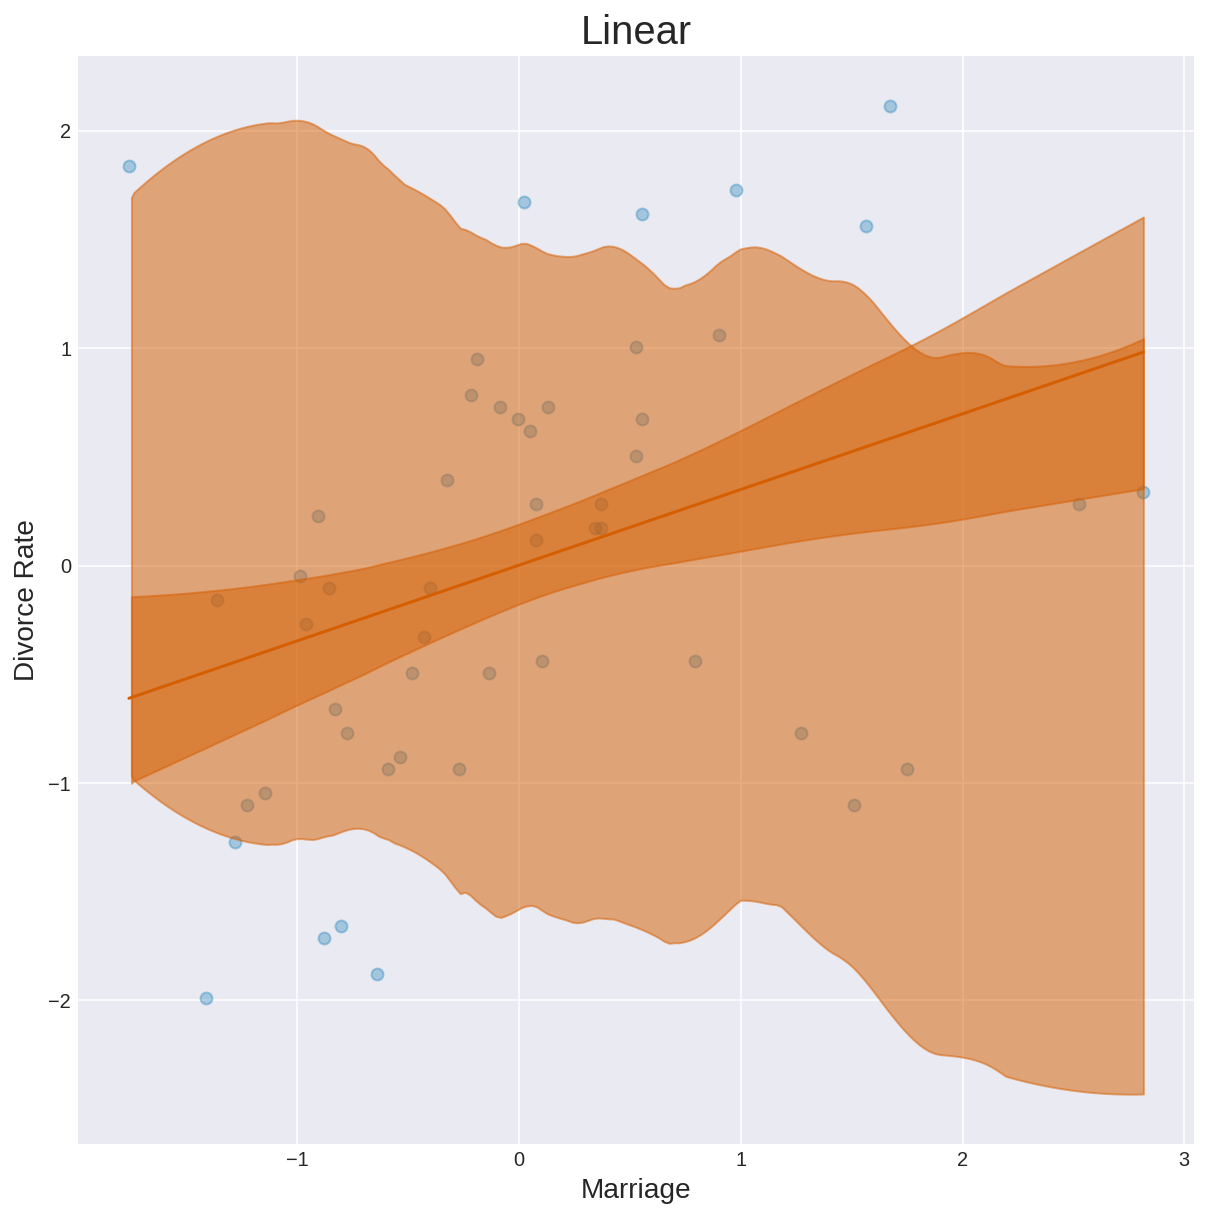

In [14]:
mu_pred = trace_5_6['mu']
y_pred = pm.sample_posterior_predictive(trace_5_6, 200, model_5_1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d.Marriage, d.Divorce, mu_pred, y_pred['divorce'], 0.9, ax, 'Linear', 'Marriage', 'Divorce Rate')

## Multiple Regression

In [15]:
# 5.10
with pm.Model() as model_5_10:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  beta = pm.Normal('beta', mu=0, sd=0.5, shape=2)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + beta[0] * d.Marriage + beta[1] * d.MedianAgeMarriage)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_10 = pm.sample(10000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:13<00:00, 799.53it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68fd416c50>,
      dtype=object)

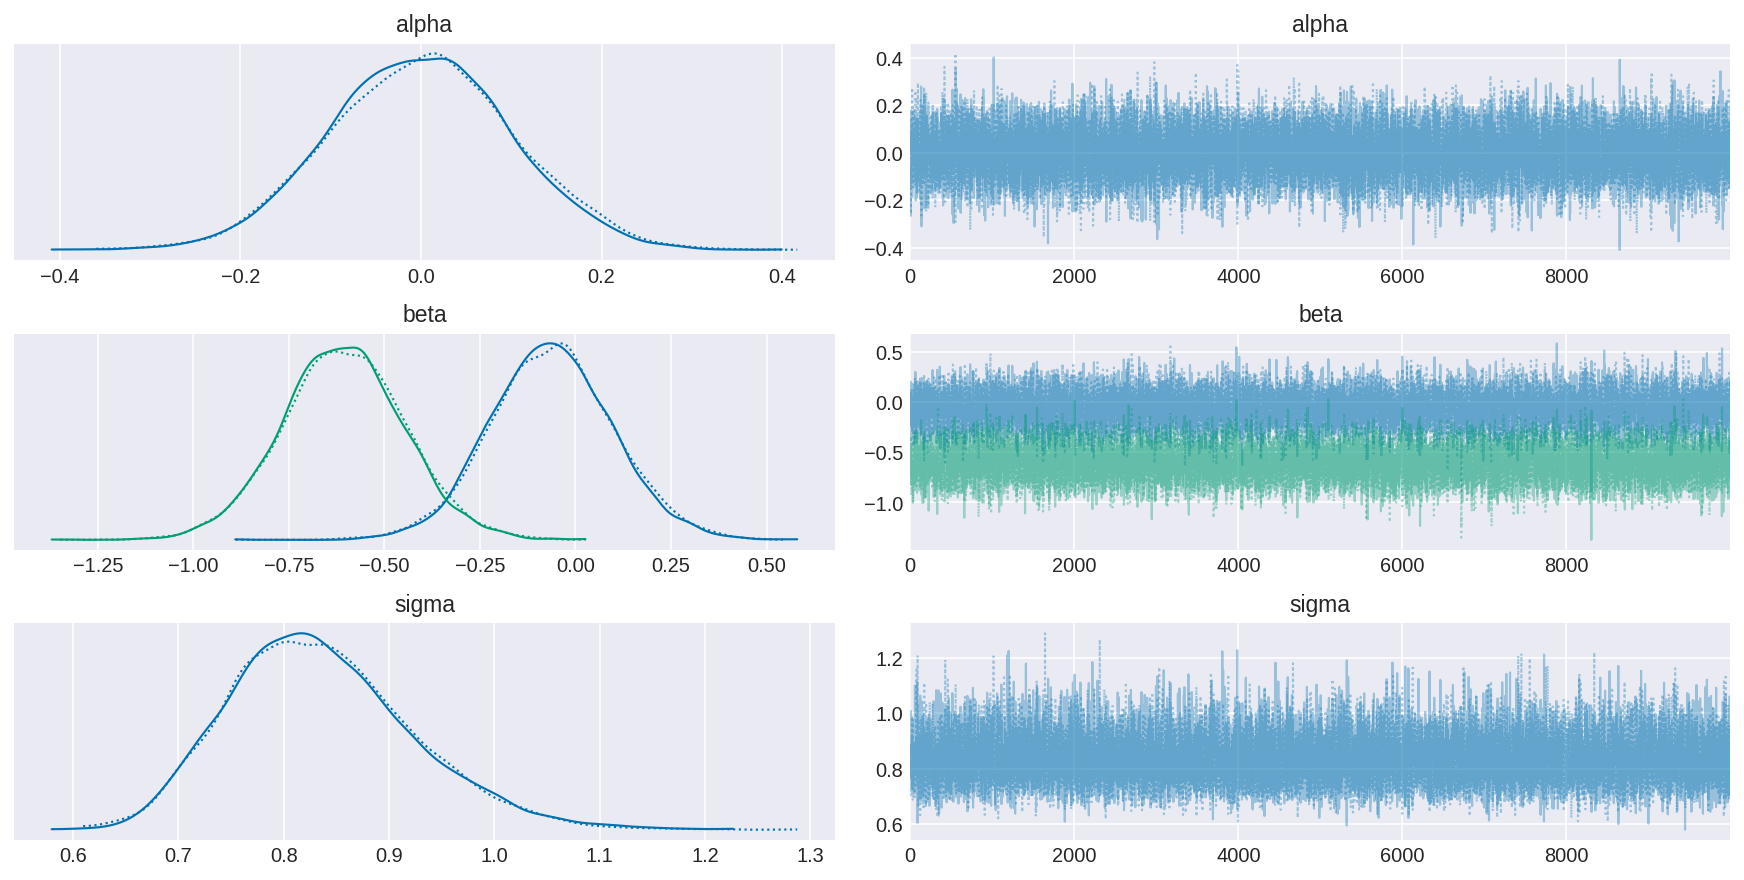

In [16]:
pm.traceplot(trace_5_10, var_names=['alpha', 'beta', 'sigma'])

In [17]:
pm.summary(trace_5_10, var_names=['alpha', 'beta', 'sigma']).round(3)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.102,-0.182,0.198,0.001,0.001,17702.0,9556.0,17698.0,14483.0,1.0
beta[0],-0.063,0.160,-0.354,0.251,0.001,0.001,11490.0,10376.0,11493.0,12994.0,1.0
beta[1],-0.609,0.161,-0.909,-0.302,0.002,0.001,11284.0,11189.0,11331.0,12440.0,1.0
sigma,0.835,0.087,0.681,1.001,0.001,0.000,15682.0,15393.0,15965.0,14260.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68f507e5c0>],
      dtype=object)

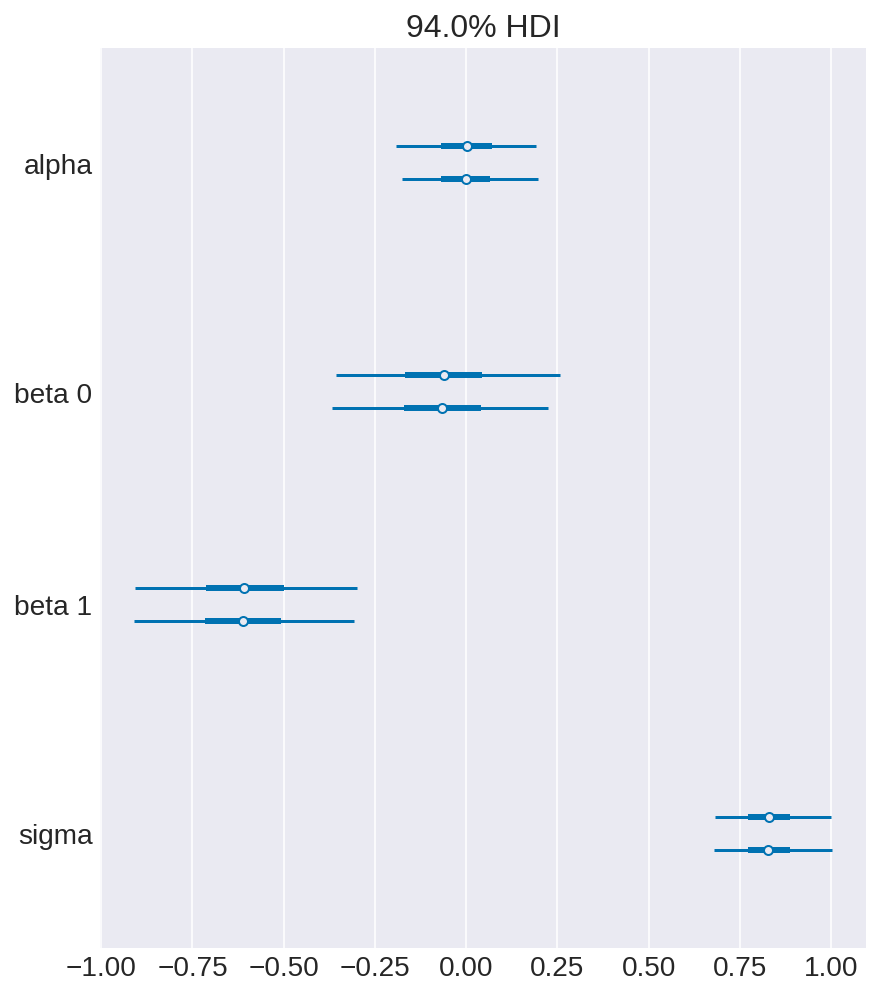

In [18]:
pm.forestplot(trace_5_10, var_names=['alpha', 'beta', 'sigma'])

beta_1 for Age is not changing compare to the previous model while the beta_0 for Merrige is changing from positive value to almost zero.

## Plotting Multivariate Posteriors
### Predictor Residual Plots
It is the average prediction error when we use all of the other predictor variables to model a predictor of interest

In [19]:
def plot_predictor_residual(x, y, mu_pred, ax, title, x_label, y_label):
  idx = np.argsort(x)
  residuals = y - mu_pred

  ax.scatter(x, y, c='C0', alpha=0.3)
  ax.plot(x[idx], mu_pred[idx], 'k')
  ax.vlines(x, mu_pred, mu_pred + residuals, colors='grey')
  
  ax.set_xlabel(x_label, fontsize=14)
  ax.set_ylabel(y_label, fontsize=14)
  ax.set_title(title, fontsize=20)

In [20]:
# Regess Age vs Marriage Rate
with pm.Model() as model_5_13:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  beta = pm.Normal('beta', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + beta * d.MedianAgeMarriage)
  rate = pm.Normal('rate', mu=mu, sd=sigma, observed=d.Marriage)
  trace_5_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1053.55it/s]


In [21]:
# Divorce Rate is regressed on the residuals from the previous model
marriage_pred = trace_5_13['mu'].mean(0)
residual = d.Marriage - marriage_pred

with pm.Model() as model_5_14:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  beta = pm.Normal('beta', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + beta * residual)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_14 = pm.sample(1000, tune=1000)
  
divorce_pred = pm.sample_posterior_predictive(trace_5_14, 200, model_5_14)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1099.50it/s]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 450.42it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


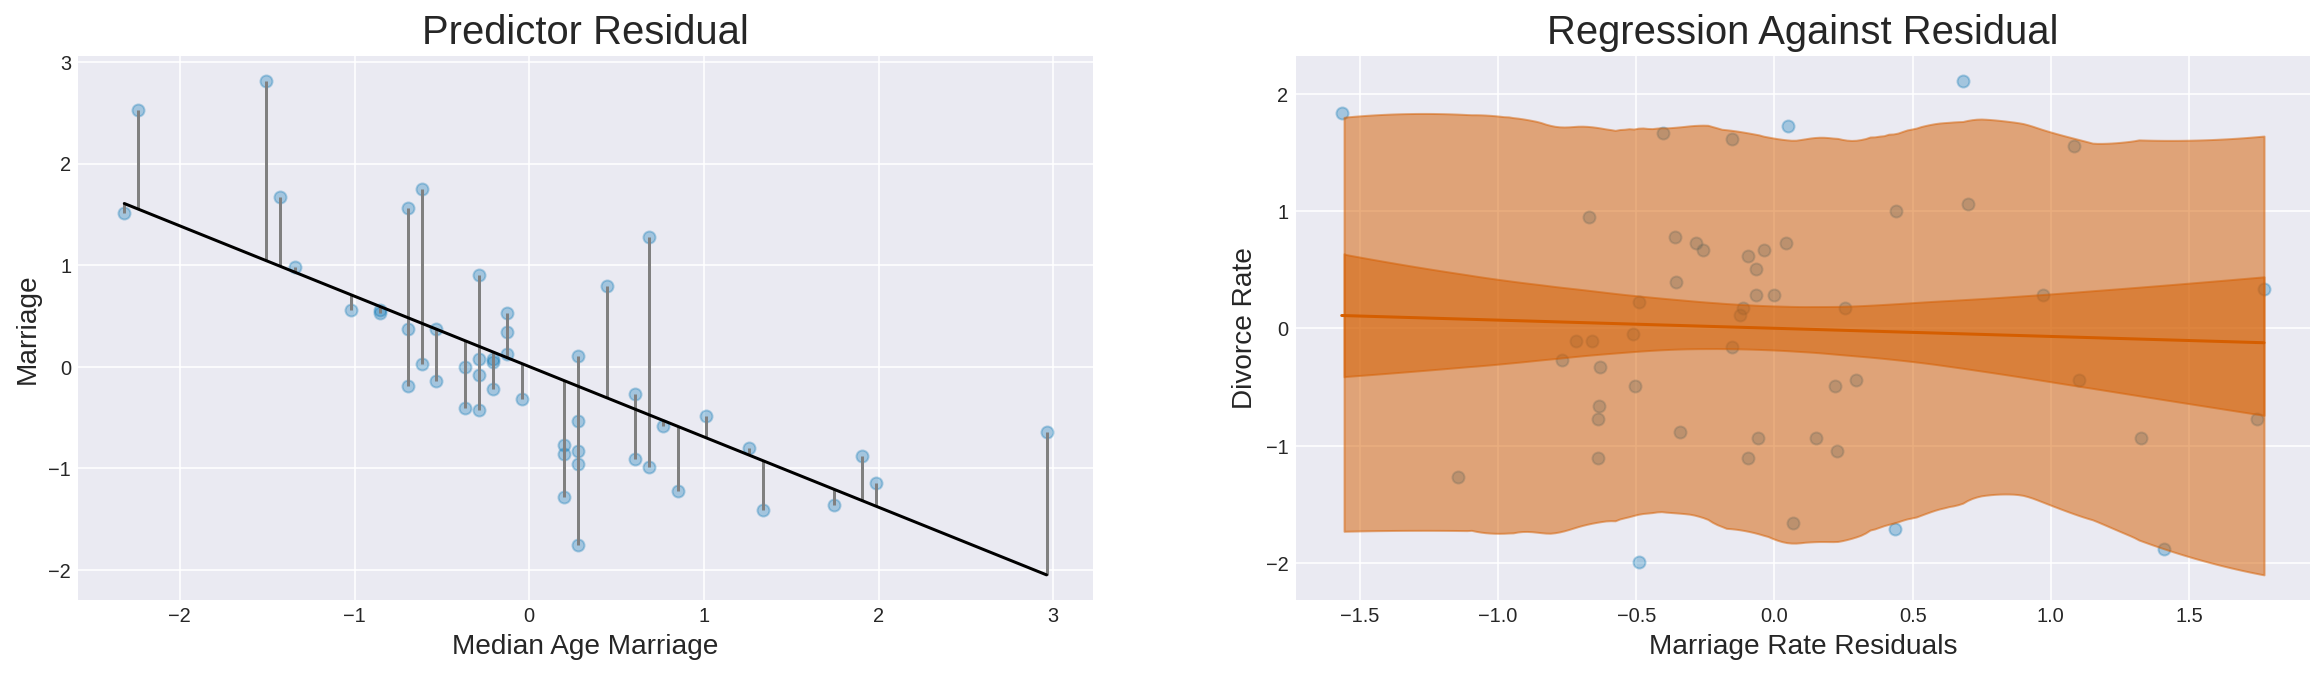

In [22]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_predictor_residual(d.MedianAgeMarriage, d.Marriage, marriage_pred, ax[0], 'Predictor Residual', 'Median Age Marriage', 'Marriage')
plot(residual, d.Divorce, trace_5_14['mu'], divorce_pred['divorce'], 0.9, ax[1], 'Regression Against Residual', 'Marriage Rate Residuals', 'Divorce Rate')

In [23]:
# Regess Marriage Rate vs Age
with pm.Model() as model_5_13_2:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  beta = pm.Normal('beta', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + beta * d.Marriage)
  rate = pm.Normal('rate', mu=mu, sd=sigma, observed=d.MedianAgeMarriage)
  trace_5_13_2 = pm.sample(1000, tune=1000)

# Divorce Rate is regressed on the residuals from the previous model
age_pred = trace_5_13_2['mu'].mean(0)
residual = d.MedianAgeMarriage - age_pred

with pm.Model() as model_5_14_2:
  alpha = pm.Normal('alpha', mu=0, sd=0.2)
  beta = pm.Normal('beta', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', alpha + beta * residual)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
  trace_5_14_2 = pm.sample(1000, tune=1000)
  
divorce_pred = pm.sample_posterior_predictive(trace_5_14_2, 200, model_5_14_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1088.11it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1085.05it/s]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 512.47it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


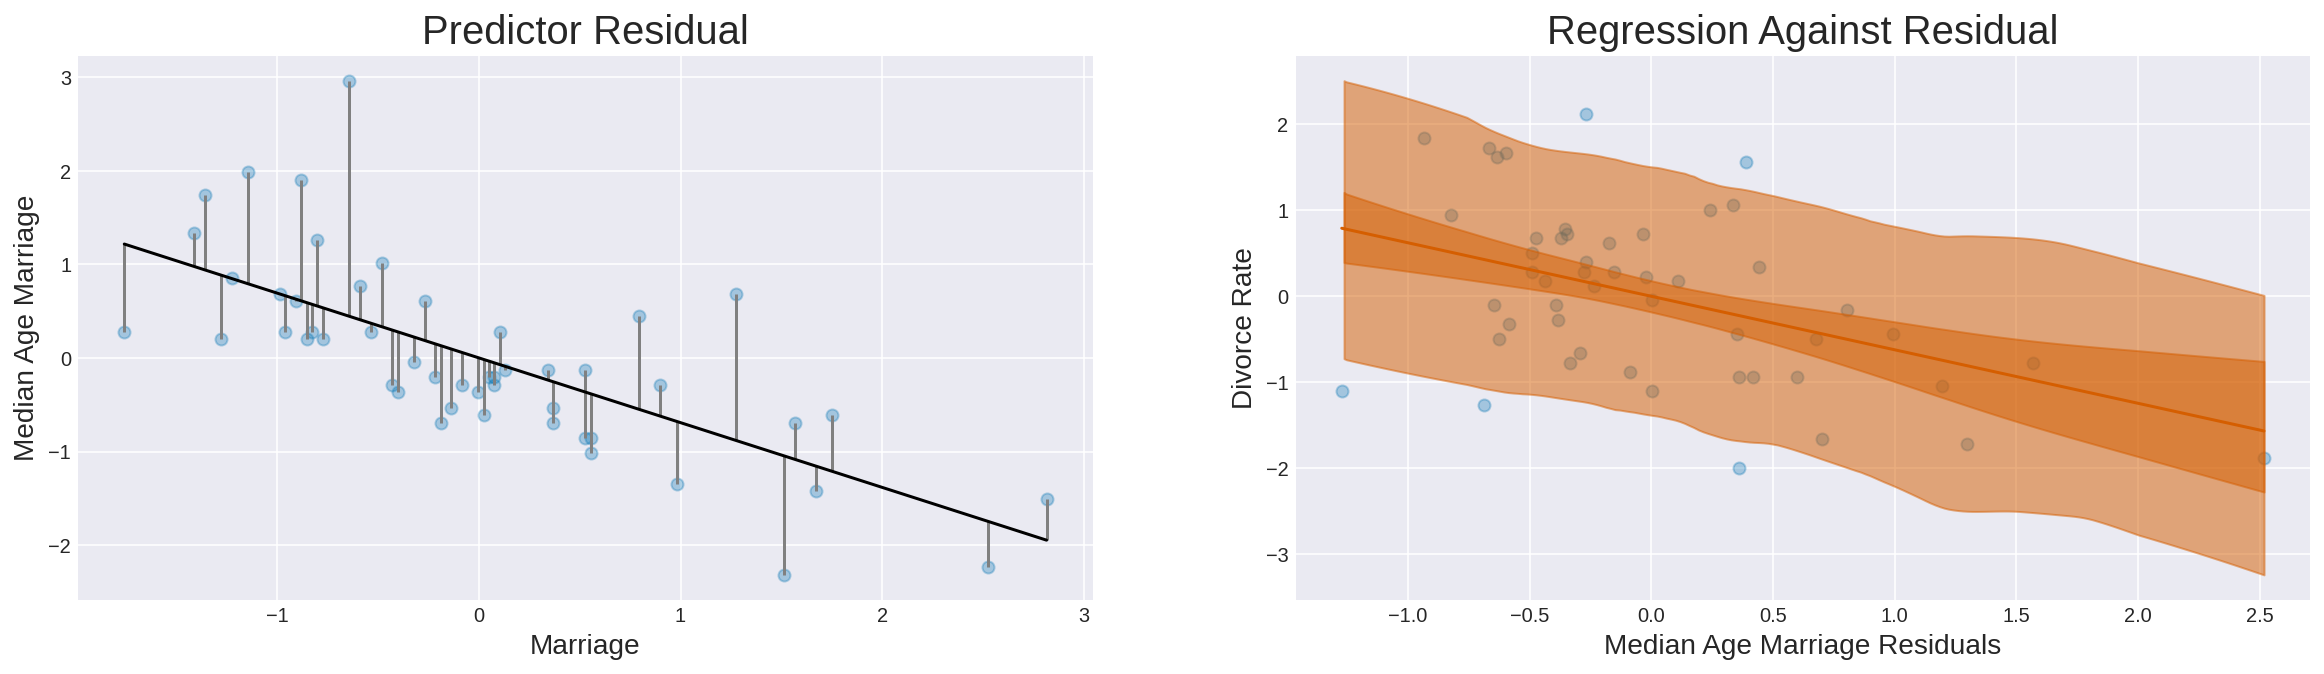

In [24]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_predictor_residual(d.Marriage, d.MedianAgeMarriage, age_pred, ax[0], 'Predictor Residual', 'Marriage', 'Median Age Marriage')
plot(residual, d.Divorce, trace_5_14_2['mu'], divorce_pred['divorce'], 0.9, ax[1], 'Regression Against Residual', 'Median Age Marriage Residuals', 'Divorce Rate')

It is not a good practice to put residual of one model as input to another model since residual are not known factors, they are just parameters and variables with unobserved values.

It is better to include the additional variables in the same model.

### Posterior Predictive Plot
It is important to check the model implied prediction aginst real world data

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 603.46it/s]


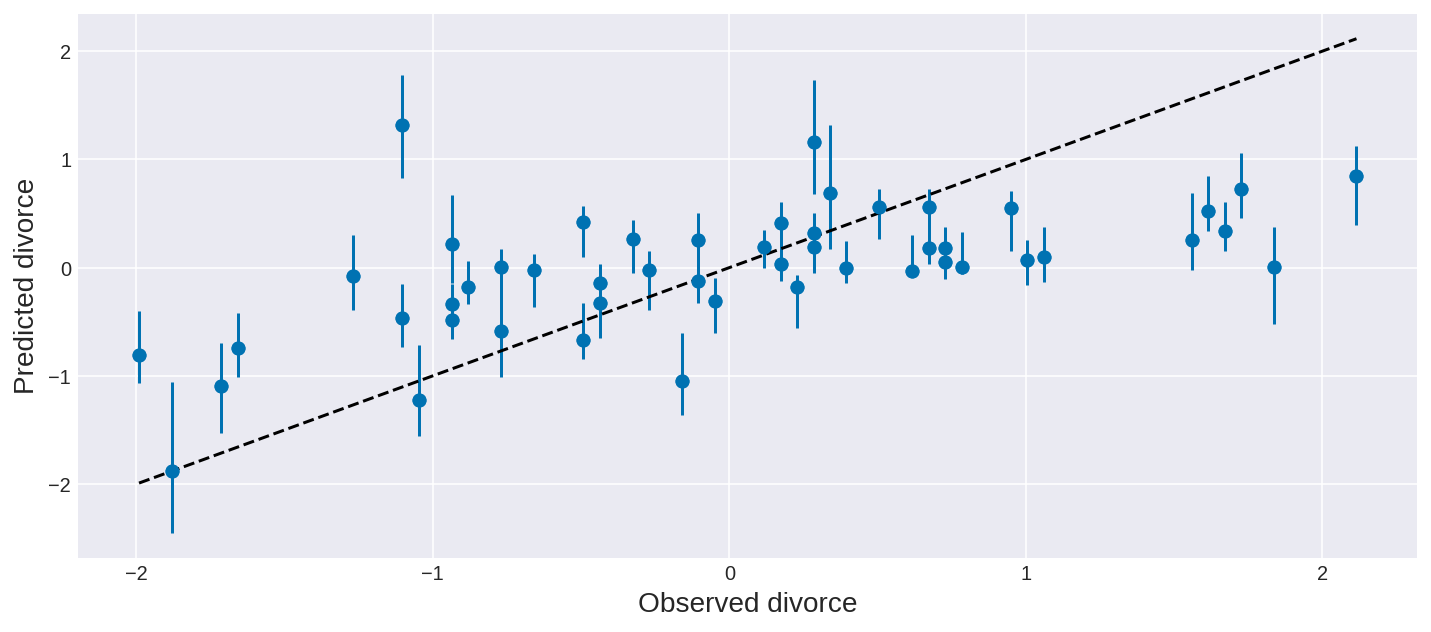

In [25]:
mu_pred = trace_5_10['mu']
mu_hpd = az.hdi(mu_pred, 0.9)

divorce_pred = pm.sample_posterior_predictive(trace_5_10, 200, model_5_10)['divorce']
divorce_hpd = az.hdi(divorce_pred, 0.9)

fig = plt.figure(figsize=(12, 5))
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0) - mu_hpd.T) , fmt='C0o')
plt.plot(d.Divorce, divorce_pred.mean(0), 'C0o')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');


### Counterfactual Plots

In [26]:
# Use Theano shared variables so we can change them later
marriage_shared = shared(d["Marriage"].values)
age_shared = shared(d["MedianAgeMarriage"].values)

with pm.Model() as model_5_19:
  # A -> D <- M
  a = pm.Normal('a', mu=0, sd=0.2)
  bM = pm.Normal('bM', mu=0, sd=0.5)
  bA = pm.Normal('bA', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', a + bA * age_shared + bM * marriage_shared)
  divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)

  # A -> M
  aM = pm.Normal('aM', mu=0, sd=0.2)
  bAM = pm.Normal('bAM', mu=0, sd=0.5)
  sigma_M = pm.Exponential('sigma_M', 1)
  mu_M = pm.Deterministic('mu_M', aM + bAM * age_shared)
  marriage = pm.Normal('marriage', mu=mu_M, sd=sigma_M, observed=d.Marriage)

  trace_5_19 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_M, bAM, aM, sigma, bA, bM, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:02<00:00, 469.36it/s]


In [27]:
# With PyMC3 we have to simulate in each model separately
age_seq = np.linspace(-2, 2, 50)

# Simulate the marriage rates at each age first
age_shared.set_value(age_seq)
with model_5_19:
    trace_5_19_marriage = pm.sample_posterior_predictive(trace_5_19)

100%|██████████| 1000/1000 [00:03<00:00, 292.94it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


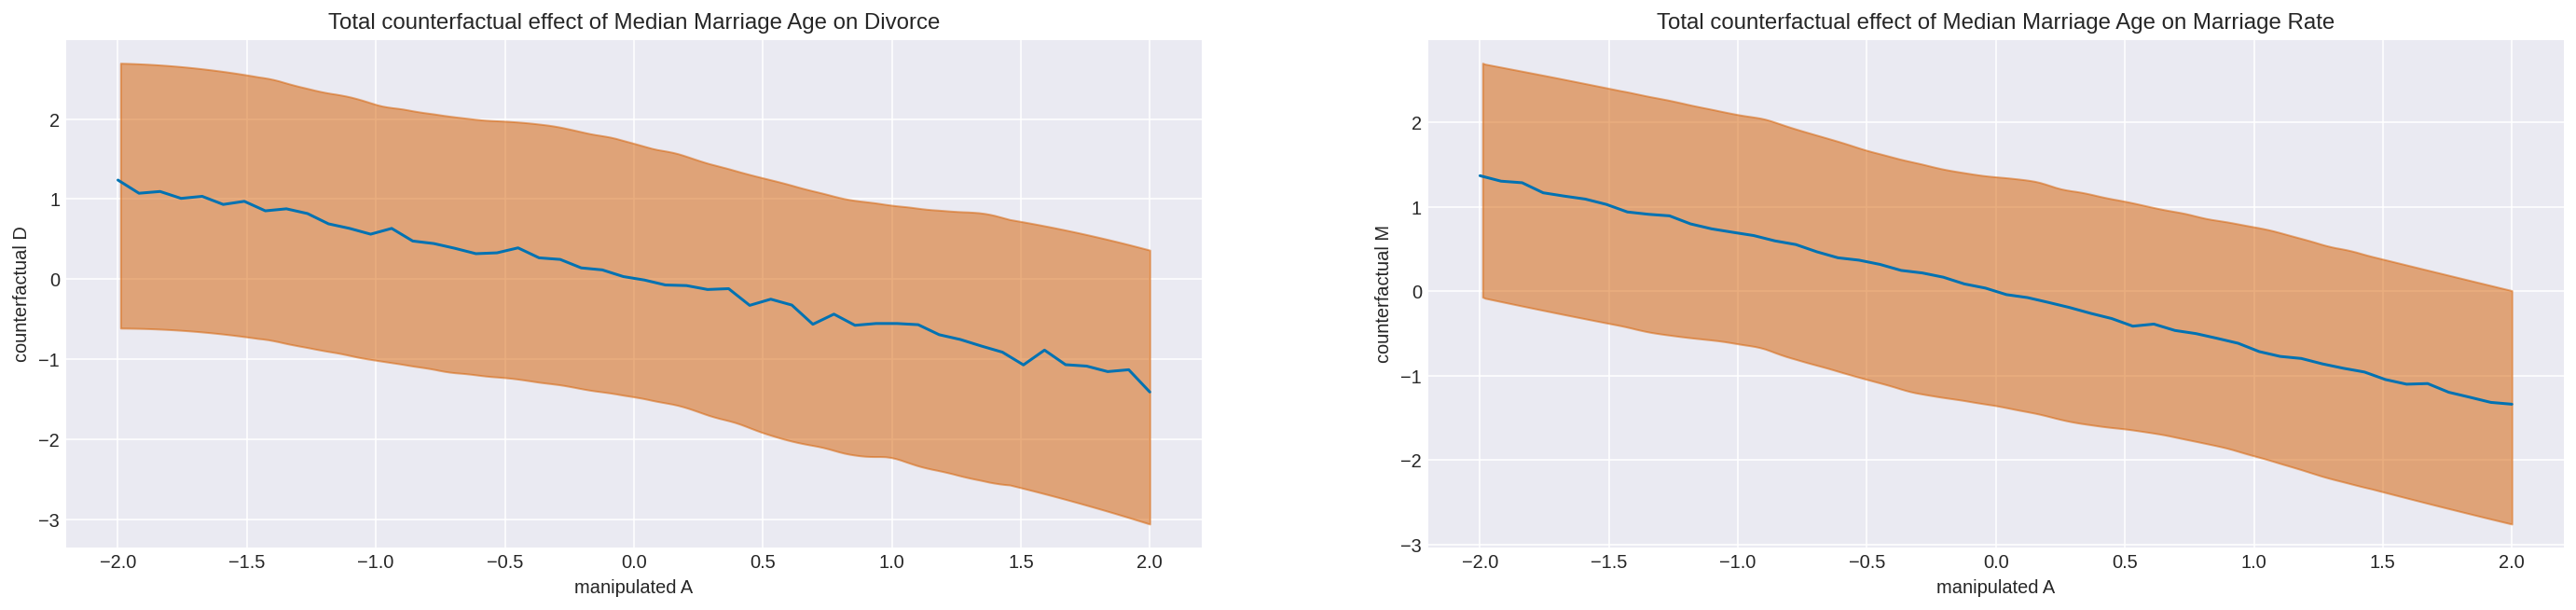

In [28]:
_, ax = plt.subplots(1, 2, figsize=(24, 5))
ax[0].plot(age_seq, trace_5_19_marriage["divorce"].mean(0))
az.plot_hpd(age_seq, trace_5_19_marriage["divorce"], ax=ax[0], color='C2')
ax[0].set_title("Total counterfactual effect of Median Marriage Age on Divorce")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


ax[1].plot(age_seq, trace_5_19_marriage["marriage"].mean(0))
az.plot_hpd(age_seq, trace_5_19_marriage["marriage"], ax=ax[1], color='C2')
ax[1].set_title("Total counterfactual effect of Median Marriage Age on Marriage Rate")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");


In [29]:
# Marriage Counterfactual
marriage_seq = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_seq)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with model_5_19:
    trace_5_19_marriage = pm.sample_posterior_predictive(trace_5_19)

100%|██████████| 1000/1000 [00:03<00:00, 281.95it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


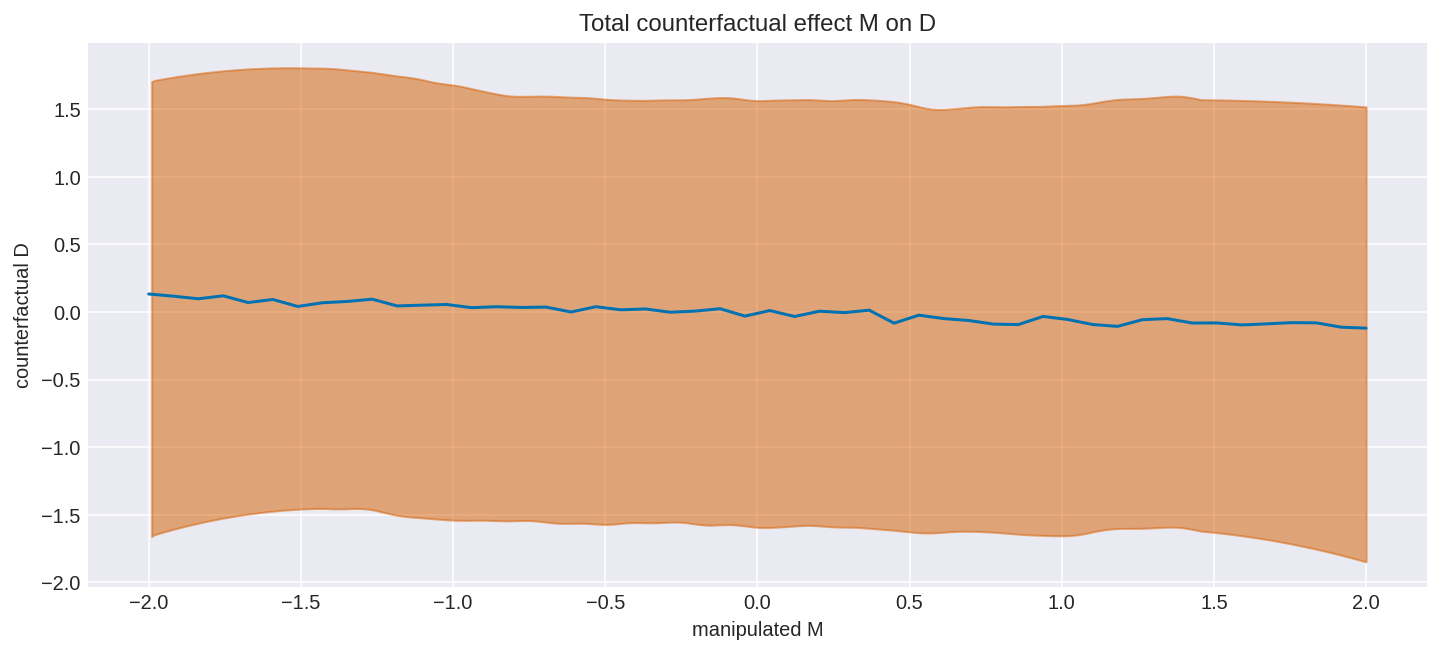

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(marriage_seq, trace_5_19_marriage["divorce"].mean(0))
az.plot_hpd(marriage_seq, trace_5_19_marriage["divorce"], ax=ax, color='C2')
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

## 5.2 Masked Relationship

In [31]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/milk.csv'
d = pd.read_csv(url, sep=';')
d.head()

# kcal.per.g: kilocaories of energy per gram of milk
# mass: average female body mass in kilograms
# neocortex.perc: percent of total brain mass that is neocortex mass

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [32]:
# Standarized Data
d['log_mass'] = np.log(d['mass'])
scaler = preprocessing.StandardScaler()
colnames = ['kcal.per.g', 'log_mass', 'neocortex.perc']
scaler.fit(d[colnames])
d[colnames] = scaler.transform(d[colnames])
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,log_mass
0,Strepsirrhine,Eulemur fulvus,-0.956680,16.60,15.42,67.98,1.95,-2.144217,-0.463904
1,Strepsirrhine,E macaco,-0.830572,19.27,16.91,63.82,2.09,NaN,-0.422348
2,Strepsirrhine,E mongoz,-1.145842,14.11,16.85,69.04,2.51,NaN,-0.312595
3,Strepsirrhine,E rubriventer,-1.019734,14.91,13.18,71.91,1.62,NaN,-0.575027
4,Strepsirrhine,Lemur catta,-0.263087,27.28,19.50,53.22,2.19,NaN,-0.394336


In [33]:
# Dropped NA
dcc = d.dropna(axis=0)
dcc.shape

(17, 9)

In [34]:
shared_N = shared(dcc["neocortex.perc"].values)
with pm.Model() as m_5_30:
  a = pm.Normal('a', mu=0, sd=1)
  bN = pm.Normal('bN', mu=0, sd=1)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', a + bN * shared_N)
  K = pm.Normal('K', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
  trace_5_30 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bN, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 1048.55it/s]


In [35]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m_5_30:
    m_5_30_prior_pred = pm.sample_prior_predictive()

In [36]:
def plot_prior(prior_pred, num, ax):
  for i in range(num):
    ax.plot(xseq, prior_pred["K"][i], c="black", alpha=0.3)
  ax.set_xlim(xseq)
  ax.set_ylim(xseq)
  ax.set_xlabel("neocortex percent (std)")
  ax.set_ylabel("kilocal per g (std)");

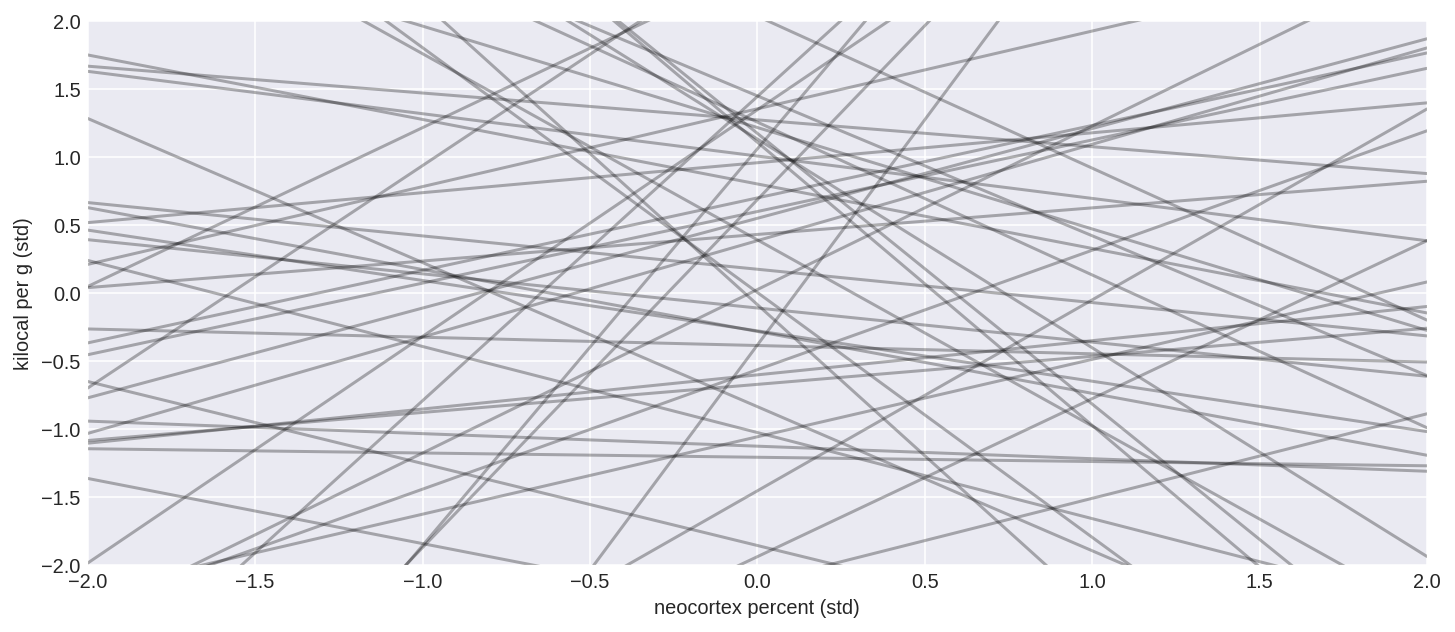

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_prior(m_5_30_prior_pred, 50, ax)

In [38]:
# Improve Prior Assumption with tigher a and bN
shared_N = shared(dcc["neocortex.perc"].values)
with pm.Model() as m_5_35:
  a = pm.Normal('a', mu=0, sd=0.2)
  bN = pm.Normal('bN', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', a + bN * shared_N)
  K = pm.Normal('K', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
  trace_5_35 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bN, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 1061.89it/s]


In [39]:
with m_5_35:
  summary = pm.summary(trace_5_35, var_names=['a', 'bN', 'sigma'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.046,0.164,-0.243,0.349,0.005,0.005,1240.0,515.0,1177.0,653.0,1.0
bN,0.119,0.251,-0.383,0.577,0.008,0.007,1006.0,653.0,1012.0,716.0,1.0
sigma,1.135,0.206,0.772,1.514,0.007,0.005,997.0,947.0,1031.0,477.0,1.0


In [40]:
xseq = np.linspace(dcc["neocortex.perc"].min() - 0.15, dcc["neocortex.perc"].max() + 0.15, 30)
shared_N.set_value(xseq)

with m_5_35:
  posterior_pred = pm.sample_posterior_predictive(trace_5_35, var_names=['mu'], samples=4000)


100%|██████████| 4000/4000 [00:01<00:00, 2342.89it/s]


In [41]:
print(posterior_pred['mu'].shape)

(4000, 30)


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


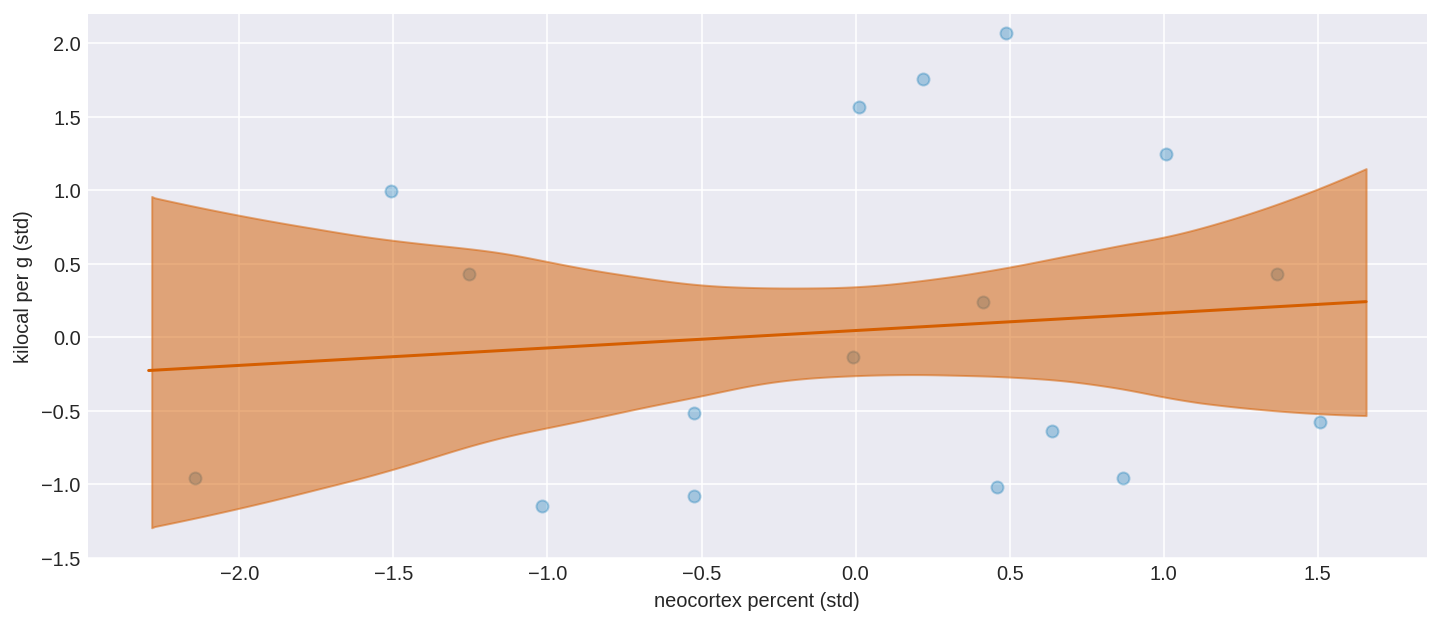

In [42]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(xseq, posterior_pred["mu"].mean(axis=0), c="C2")
ax.scatter(dcc["neocortex.perc"], dcc["kcal.per.g"], c='C0', alpha=0.3)
az.plot_hpd(xseq, posterior_pred["mu"], ax=ax, color='C2')
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

In [43]:
shared_M = shared(dcc["log_mass"].values)
with pm.Model() as m_5_38:
  a = pm.Normal('a', mu=0, sd=0.2)
  bM = pm.Normal('bM', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', a + bM * shared_M)
  K = pm.Normal('K', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
  trace_5_38 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bM, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 1147.14it/s]


In [44]:
with m_5_38:
  summary = pm.summary(trace_5_38, var_names=['a', 'bM', 'sigma'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.042,0.145,-0.232,0.298,0.004,0.005,1191.0,492.0,1190.0,616.0,1.0
bM,-0.276,0.195,-0.607,0.106,0.006,0.004,1134.0,1104.0,1143.0,801.0,1.0
sigma,1.075,0.198,0.742,1.470,0.006,0.005,945.0,881.0,1010.0,745.0,1.0


In [45]:
xseq = np.linspace(dcc["log_mass"].min() - 0.15, dcc["log_mass"].max() + 0.15, 30)
shared_M.set_value(xseq)

with m_5_38:
  posterior_pred = pm.sample_posterior_predictive(trace_5_38, var_names=['mu'], samples=4000)

100%|██████████| 4000/4000 [00:01<00:00, 2147.51it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


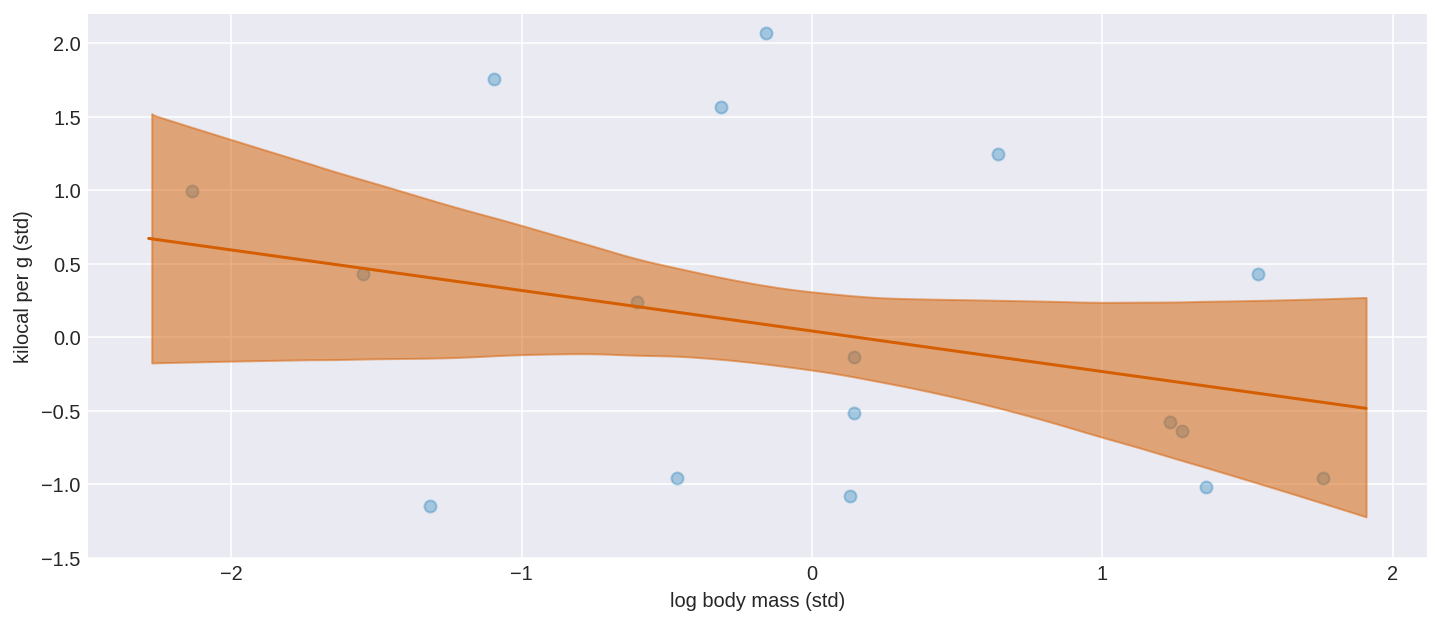

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(xseq, posterior_pred["mu"].mean(axis=0), c="C2")
ax.scatter(dcc["log_mass"], dcc["kcal.per.g"], c='C0', alpha=0.3)
az.plot_hpd(xseq, posterior_pred["mu"], ax=ax, color='C2')
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("kilocal per g (std)");

In [47]:
shared_M = shared(dcc["log_mass"].values)
shared_N = shared(dcc["neocortex.perc"].values)

with pm.Model() as m_5_39:
  a = pm.Normal('a', mu=0, sd=0.2)
  bM = pm.Normal('bM', mu=0, sd=0.5)
  bN = pm.Normal('bN', mu=0, sd=0.5)
  sigma = pm.Exponential('sigma', 1)
  mu = pm.Deterministic('mu', a + bM * shared_M + bN * shared_N)
  K = pm.Normal('K', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
  trace_5_39 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bN, bM, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 795.61it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68f8f98cc0>],
      dtype=object)

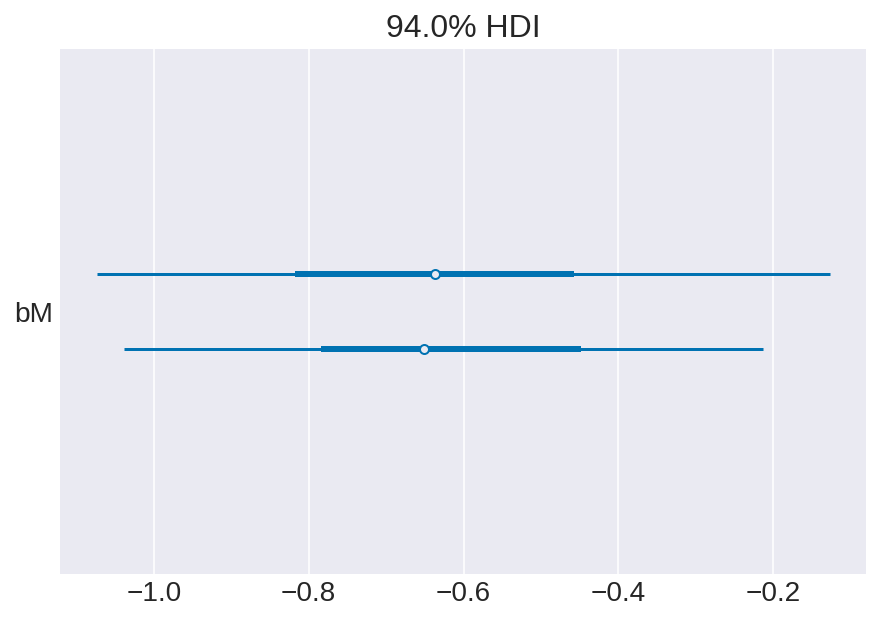

In [48]:
pm.forestplot(trace_5_39, var_names = ['bM'])

In [49]:
n_seq = np.linspace(-2, 2, 50)
shared_N.set_value(n_seq)
shared_M.set_value(np.zeros(50))

with m_5_39:
    posterior_pred_N = pm.sample_posterior_predictive(trace_5_39, var_names=['mu'], samples=4000)

100%|██████████| 4000/4000 [00:01<00:00, 2484.21it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


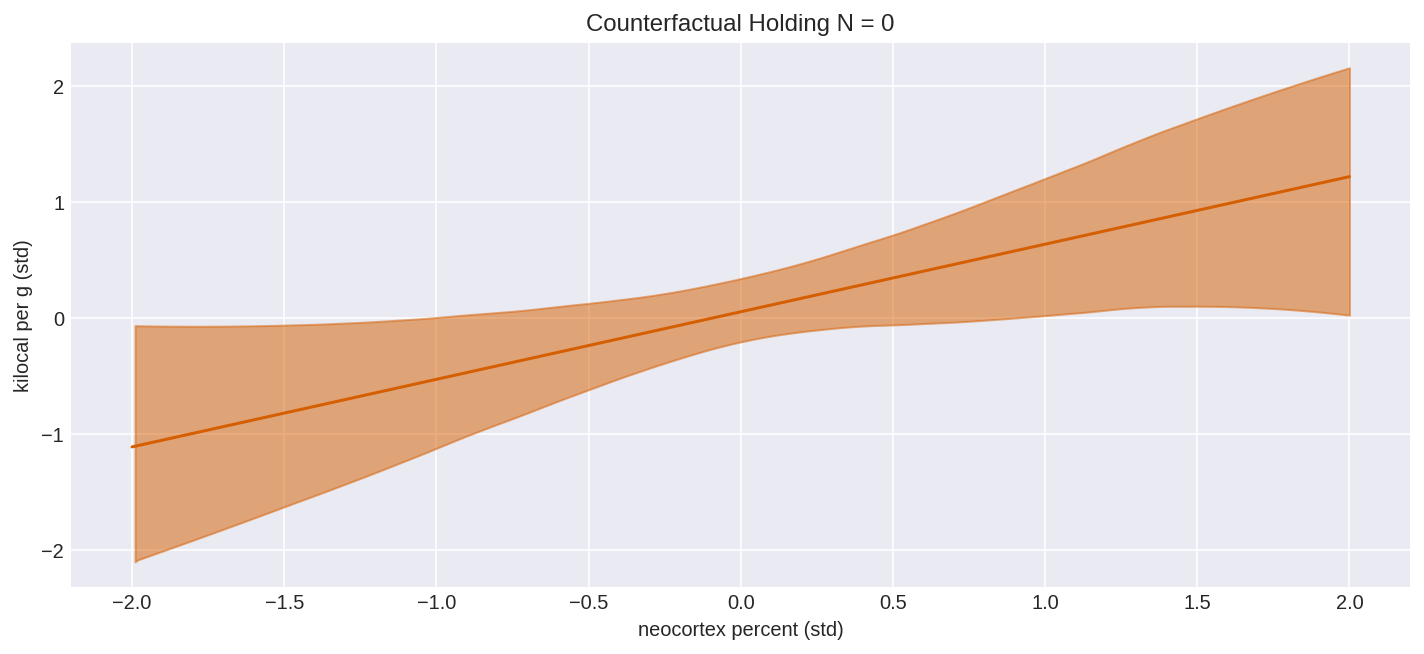

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(n_seq, posterior_pred_N["mu"].mean(axis=0), c="C2")
az.plot_hpd(n_seq, posterior_pred_N["mu"], ax=ax, color='C2')
ax.set_title("Counterfactual Holding N = 0")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

In [51]:
m_seq = np.linspace(-2, 2, 50)
shared_M.set_value(m_seq)
shared_N.set_value(np.zeros(50))

with m_5_39:
    posterior_pred_M = pm.sample_posterior_predictive(trace_5_39, var_names=['mu'], samples=4000)

100%|██████████| 4000/4000 [00:01<00:00, 2329.10it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


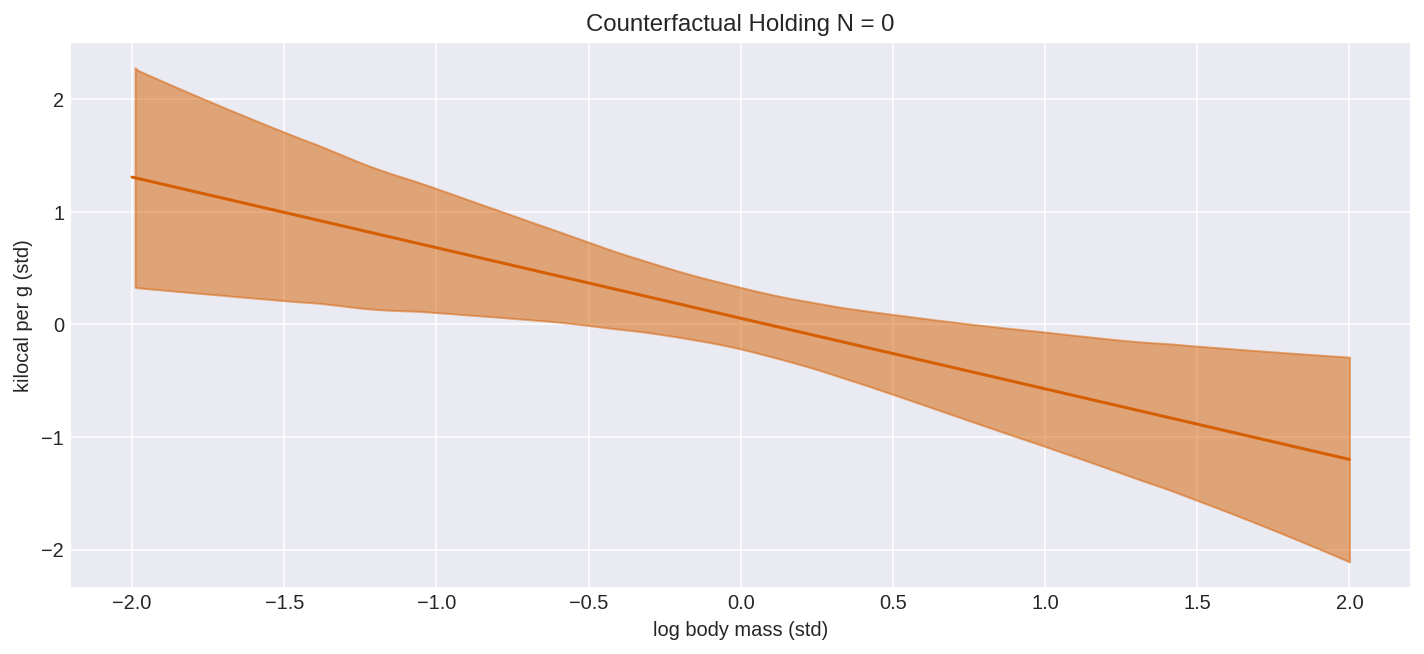

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(m_seq, posterior_pred_M["mu"].mean(axis=0), c="C2")
az.plot_hpd(m_seq, posterior_pred_M["mu"], ax=ax, color='C2')
ax.set_title("Counterfactual Holding N = 0")
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("kilocal per g (std)");